In [17]:
import ee
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project="biodiversitymeetsdata")

# Functions

In [7]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['longitude', 'latitude','time','datetime',  *list_of_bands]]

    return df

def extractRow(featureRow, bands):
    """
    Extracts all relevant information from a pixel contained within the JSON object
    
    Args:
        featureRow (dict): A dictionary which is part of the jsonObj["features"] list
        bands (list): A list containing the bands of interest that are selected from the Image instance
        
    Returns:
        valueDict (dict): A dictionary where the longitude, latitude and bands are mapped to their corresponding 
                          values in the json object from the sampleRegions function
    """
    featureKeys=["longitude", "latitude", *bands]
    values = list(itertools.chain([featureRow["geometry"]["coordinates"][0], featureRow["geometry"]["coordinates"][1]],
                                      [featureRow["properties"][key] for key in bands]))
    return dict(zip(featureKeys, values))

import pandas as pd

def jsonToDf(jsonObj, bands):
    data=[extractRow(featureRow, bands) for featureRow in jsonObj["features"]]
    return pd.DataFrame(data)

In [8]:
def bbox_to_rect(bbox_dict):
    return ee.Geometry.Rectangle([
        bbox_dict["west"], bbox_dict["south"],
        bbox_dict["east"], bbox_dict["north"]
    ])

In [9]:
def sampleImage(img, bands, geomObj, scale):
    #Select the bands of interest from the image
    imgBands = img.select(*bands)
    return imgBands.sampleRegions(collection=ee.FeatureCollection([geomObj]),
                                  scale=scale,
                                  geometries=True).getInfo()

def sampleIC(IC, bands, geomObj, scale):
    #Select the bands of interest from the image collection
    IC=IC.select(*bands)
    return IC.getRegion(geomObj, scale=scale).getInfo()

In [10]:
class_labels = {
    10: "Tree cover",
    20: "Schrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built up",
    60: "Bare / sparse vegetation",
    70: "Snow and ice",
    80: "Permanent Water Bodies",
    90: "Herbaceous wetland",
    95: "Man groves",
    100: "Moss and lichen"
}

class_colors = {
10:"#006400",#Tree cover
20:"#ffbb22",#Shrubland
30:"#ffff4c",#Grassland
40:"#f096ff",#Cropland
50:"#fa0000",#Built-up
60:"#b4b4b4",#Bare / sparse vegetation
70:"#f0f0f0",#Snow and ice
80:"#0064c8",#Permanent water bodies
90:"#0096a0",#Herbaceous wetland
95:"#00cf75",#Mangroves
100:"#fae6a0"#Moss and lichen
}

def visualiseWorldCover(df):
    colors = [class_colors[label] for label in df["Map"]]
    plt.scatter(df['longitude'], df['latitude'], c=colors, s=5, alpha=0.7)
    for label, color in class_colors.items():
        plt.scatter([], [], c=color, label=f'{class_labels[label]}', s=50)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Shared variables

In [29]:
# bounding boxes
meiseSpatial = {"west": 4.312323, "south": 50.922796, "east": 4.335497, "north": 50.934860}
bxlSpatial = {"west": 4.264069, "south": 50.696458, "east": 4.984360, "north": 50.940258}
belgiumSpatial = {"west": 2.537842, "south": 49.500242, "east": 6.388550, "north": 51.515580}
europeSpatial = {"west": -23.203125, "south": 34.452218, "east": 30.937500, "north": 71.074056}

# Convert to ee.Geometry.Rectangle
meise_roi = bbox_to_rect(meiseSpatial)
bxl_roi = bbox_to_rect(bxlSpatial)
belgium_roi = bbox_to_rect(belgiumSpatial)
europe_roi = bbox_to_rect(europeSpatial)

In [46]:
import geopandas as gpd
gdf = gpd.read_file("../../data/Belgium_shapefile/be_10km.shp")

In [47]:
gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.001, preserve_topology=True)
geojson = gdf.__geo_interface__
ee_fc = ee.FeatureCollection(geojson)

In [95]:
ee.Authenticate()
ee.Initialize(project="biodiversitymeetsdata")

# ESA World Cover

In [34]:
ic = ee.ImageCollection('ESA/WorldCover/v200')

In [41]:
sampledImg = sampleIC(ic, ["Map"], belgium_roi, 400)

In [42]:
sampledImg

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2021', 6.218138396675328, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.221731657811806, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.225324918948284, 49.50256204669035, 1609455600000, 10],
 ['2021', 6.228918180084762, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.232511441221241, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.236104702357719, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.239697963494197, 49.50256204669035, 1609455600000, 30],
 ['2021', 6.243291224630675, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.246884485767152, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.250477746903631, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.254071008040109, 49.50256204669035, 1609455600000, 40],
 ['2021', 6.257664269176587, 49.50256204669035, 1609455600000, 10],
 ['2021', 6.261257530313065, 49.50256204669035, 1609455600000, 10],
 ['2021', 6.264850791449543, 49.50256204669035, 1609455600000, 10],

In [ ]:
sampledImg2 = sampleIC(ic, ["Map"], ee_fc, 400)

## Meise

In [190]:
worldCoverMeise = dataset.getRegion(meise_roi, scale=10).getInfo()
worldCoverMeise

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 4.312407437179969, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.3124972687083805, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312587100236793, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312676931765204, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312766763293617, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.312856594822029, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.3129464263504405, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313036257878853, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313126089407264, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313215920935677, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313305752464088, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.3133955839925004, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313485415520912, 50.92284342664752, 1577836800000, 10],
 ['2020', 4.313575247049324, 50.92284342664752, 1577836800000, 1

In [191]:
mapMeise = ee_array_to_df(worldCoverMeise, ["Map"])

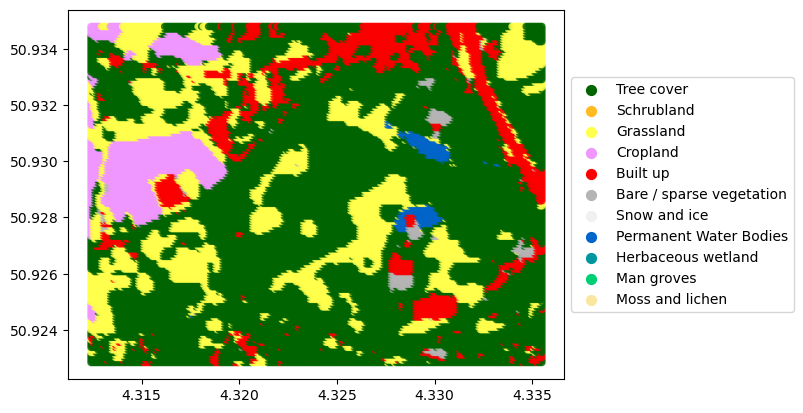

In [192]:
visualiseWorldCover(mapMeise)

## Brussels

In [196]:
worldCoverBxl = dataset.getRegion(bxl_roi, scale=100).getInfo()
worldCoverBxl

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 4.264751811357429, 50.69687221692726, 1577836800000, 10],
 ['2020', 4.265650126641548, 50.69687221692726, 1577836800000, 50],
 ['2020', 4.266548441925668, 50.69687221692726, 1577836800000, 50],
 ['2020', 4.267446757209787, 50.69687221692726, 1577836800000, 30],
 ['2020', 4.268345072493907, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.269243387778026, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.270141703062146, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.271040018346265, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.271938333630385, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.272836648914504, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.273734964198623, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.274633279482743, 50.69687221692726, 1577836800000, 40],
 ['2020', 4.275531594766862, 50.69687221692726, 1577836800000, 30],
 ['2020', 4.276429910050982, 50.69687221692726, 1577836800000, 50],

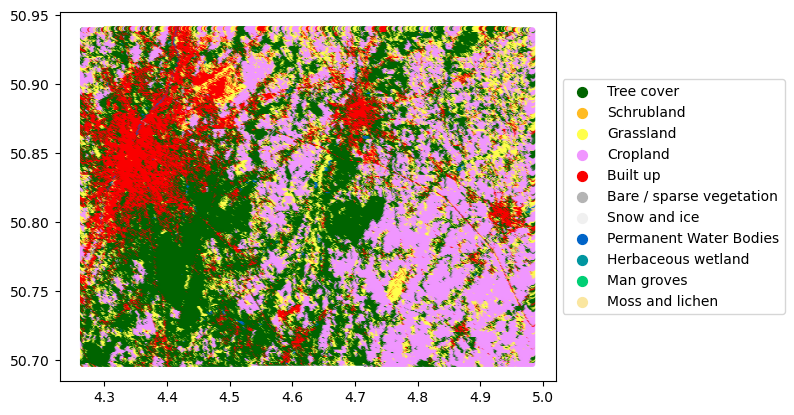

In [199]:
mapBxl = ee_array_to_df(worldCoverBxl, ["Map"])
visualiseWorldCover(mapBxl)

## Belgium

In [207]:
worldCoverBE = dataset.getRegion(belgium_roi, scale=500).getInfo()
worldCoverBE 

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 2.539986465847947, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.544478042268545, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.548969618689142, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.55346119510974, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5579527715303376, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5624443479509353, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5669359243715326, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5714275007921303, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.575919077212728, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.580410653633326, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.584902230053923, 49.503909519616535, 1577836800000, 10],
 ['2020', 2.5893938064745208, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.5938853828951185, 49.503909519616535, 1577836800000, 40],
 ['2020', 2.598376959315716, 49.503909519616535, 

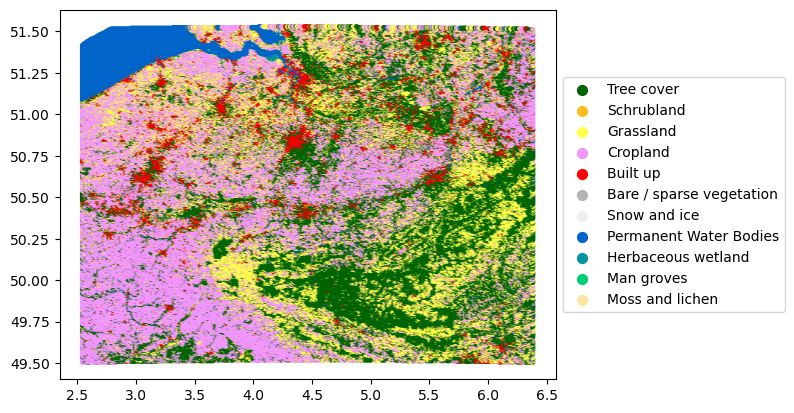

In [208]:
mapBE = ee_array_to_df(worldCoverBE, ["Map"])
visualiseWorldCover(mapBE)

## Europe

In [213]:
worldCoverEU = dataset.getRegion(europe_roi, scale=5000).getInfo()
worldCoverEU 

[['id', 'longitude', 'latitude', 'time', 'Map'],
 ['2020', 30.87958789160855, 34.472849028086635, 1577836800000, None],
 ['2020', 30.924503655814526, 34.472849028086635, 1577836800000, None],
 ['2020', 30.65500907057867, 34.51776479229261, 1577836800000, None],
 ['2020', 30.699924834784646, 34.51776479229261, 1577836800000, None],
 ['2020', 30.74484059899062, 34.51776479229261, 1577836800000, None],
 ['2020', 30.7897563631966, 34.51776479229261, 1577836800000, None],
 ['2020', 30.834672127402573, 34.51776479229261, 1577836800000, None],
 ['2020', 30.87958789160855, 34.51776479229261, 1577836800000, None],
 ['2020', 30.924503655814526, 34.51776479229261, 1577836800000, None],
 ['2020', 30.475346013754766, 34.56268055649859, 1577836800000, None],
 ['2020', 30.52026177796074, 34.56268055649859, 1577836800000, None],
 ['2020', 30.56517754216672, 34.56268055649859, 1577836800000, None],
 ['2020', 30.610093306372693, 34.56268055649859, 1577836800000, None],
 ['2020', 30.65500907057867, 34.56

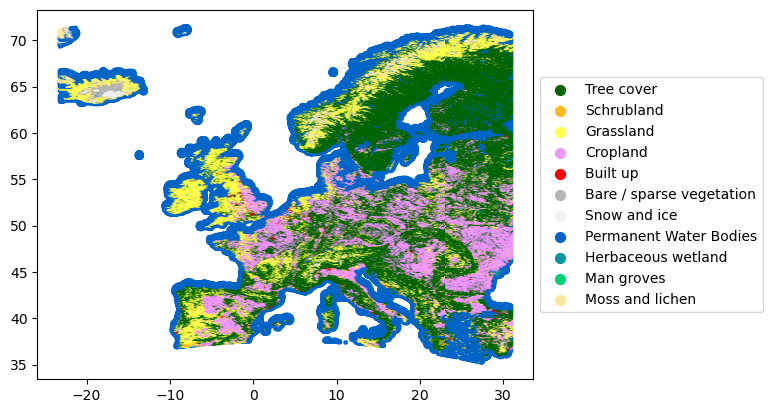

In [214]:
mapEU = ee_array_to_df(worldCoverEU, ["Map"])
visualiseWorldCover(mapEU)

# Elevation

In [219]:
# Import the USGS ground elevation image.
elevation = ee.Image('USGS/SRTMGL1_003').
elevation.getInfo()

{'type': 'Image',
 'bands': [{'id': 'elevation',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'dimensions': [1296001, 417601],
   'crs': 'EPSG:4326',
   'crs_transform': [0.0002777777777777778,
    0,
    -180.0001388888889,
    0,
    -0.0002777777777777778,
    60.00013888888889]}],
 'version': 1641990767055141,
 'id': 'USGS/SRTMGL1_003',
 'properties': {'system:visualization_0_min': '0.0',
  'type_name': 'Image',
  'keywords': ['dem',
   'elevation',
   'geophysical',
   'nasa',
   'srtm',
   'topography',
   'usgs'],
  'thumb': 'https://mw1.google.com/ges/dd/images/SRTM90_V4_thumb.png',
  'description': '<p>The Shuttle Radar Topography Mission (SRTM, see <a href="https://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on a near-global scale. This\nSRTM V3 product (SRTM Plus) is provided by NASA JP

## Meise

In [220]:
elevationMeise = elevation.getRegion(roi_Meise , scale=30).getInfo()

AttributeError: 'Image' object has no attribute 'getRegion'

## Brussels

## Belgium

## Europe